# Time Series Forecasting - Bitcoins

In [1]:
!pip install numpy==2.1.2 pandas==2.2.3 matplotlib==3.9.2 statsmodels==0.14.4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
raw_df = pd.read_csv('Bitcoin_06_11_2020-07_11_2024_historical_data_coinmarketcap.csv', sep=";")
raw_df.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
0,2024-10-01T00:00:00.000Z,2024-10-31T23:59:59.999Z,2024-10-29T19:12:00.000Z,2024-10-10T18:27:00.000Z,2781,63335.603584,73577.209658,58895.207808,70215.185633,1.049276e+12,1.388608e+12,2024-10-31T23:59:59.999Z
1,2024-09-01T00:00:00.000Z,2024-09-30T23:59:59.999Z,2024-09-27T14:39:00.000Z,2024-09-06T21:01:00.000Z,2781,58969.799454,66480.694710,52598.699662,63329.498129,9.352285e+11,1.251462e+12,2024-09-30T23:59:59.999Z
2,2024-08-01T00:00:00.000Z,2024-08-31T23:59:59.999Z,2024-08-01T22:27:00.000Z,2024-08-05T06:25:00.000Z,2781,64625.840445,65593.244771,49121.237378,58969.898366,1.076531e+12,1.164523e+12,2024-08-31T23:59:59.999Z
3,2024-07-01T00:00:00.000Z,2024-07-31T23:59:59.999Z,2024-07-29T13:07:00.000Z,2024-07-05T04:20:00.000Z,2781,62673.606339,69987.542208,53717.375433,64619.249649,9.533956e+11,1.275323e+12,2024-07-31T23:59:59.999Z
4,2024-06-01T00:00:00.000Z,2024-06-30T23:59:59.999Z,2024-06-07T12:17:00.000Z,2024-06-24T20:31:00.000Z,2781,67489.611777,71907.848983,58601.700072,62678.292079,7.517268e+11,1.235945e+12,2024-06-30T23:59:59.999Z


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeOpen   47 non-null     object 
 1   timeClose  47 non-null     object 
 2   timeHigh   47 non-null     object 
 3   timeLow    47 non-null     object 
 4   name       47 non-null     int64  
 5   open       47 non-null     float64
 6   high       47 non-null     float64
 7   low        47 non-null     float64
 8   close      47 non-null     float64
 9   volume     47 non-null     float64
 10  marketCap  47 non-null     float64
 11  timestamp  47 non-null     object 
dtypes: float64(6), int64(1), object(5)
memory usage: 4.5+ KB


In [5]:
df = pd.DataFrame()
df["Date"] = pd.to_datetime(raw_df.timestamp)
df["Date"] = df.Date.apply(lambda row: row.date())
df["Date"] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df["Date"] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df["Value"] = raw_df.close.copy()
df = df.sort_values(by='Date')
df = df.set_index("Date")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2020-12-31 to 2024-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   47 non-null     float64
dtypes: float64(1)
memory usage: 752.0 bytes
None


,Value
Date,
2020-12-31,29001.719822
2021-01-31,33114.357748
2021-02-28,45137.770468
2021-03-31,58918.832714
2021-04-30,57750.177346


<Axes: xlabel='Date'>

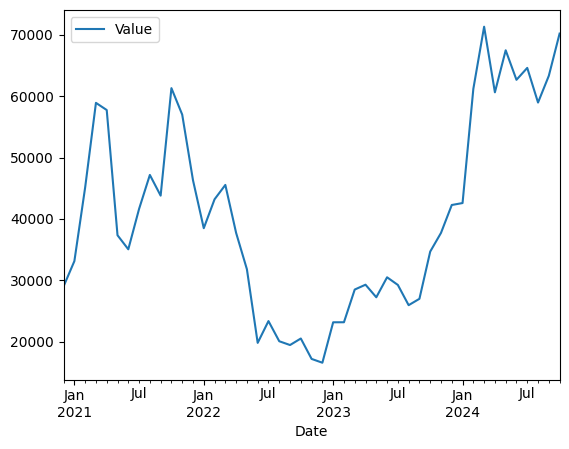

In [6]:
df.plot()

<Axes: title={'center': 'Value'}, xlabel='month'>

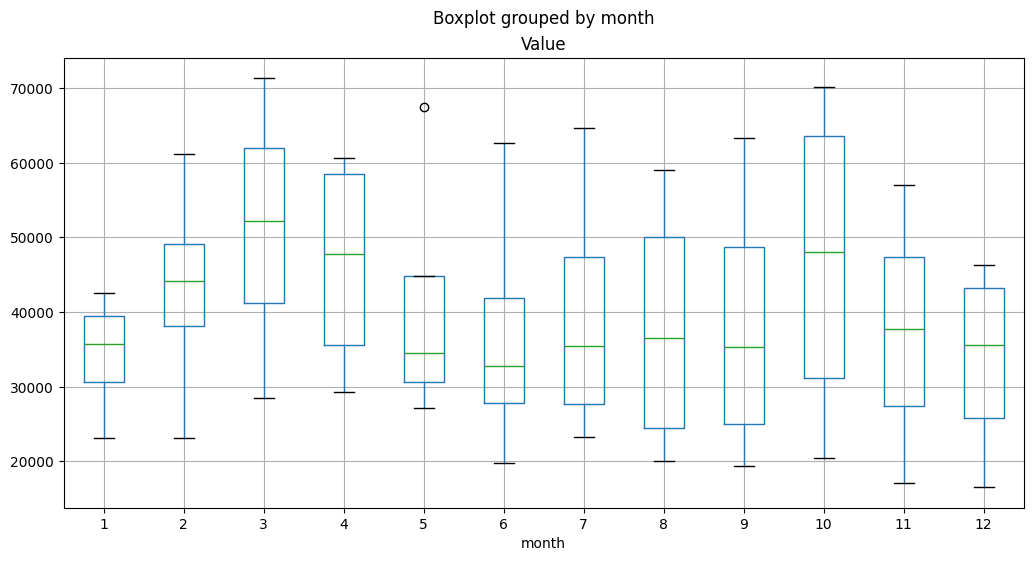

In [7]:
df.assign(month=df.index.month).boxplot(column='Value', by='month', figsize=(12, 6))

In [8]:
def check_stationarity(series):
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


check_stationarity(df["Value"])

ADF Statistic: -1.137682
p-value: 0.699813
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602
Non-stationary


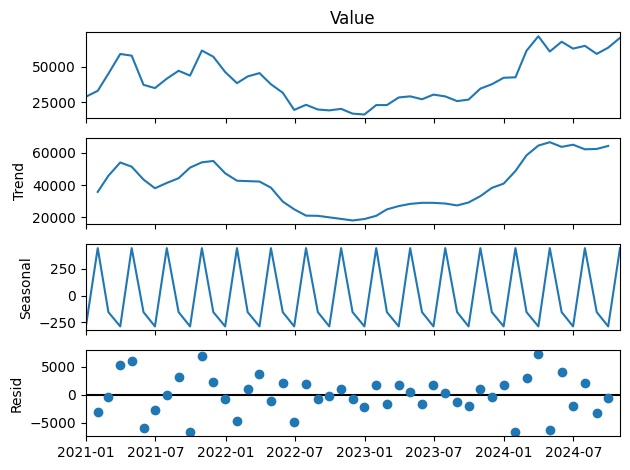

In [9]:
decomposition_add = seasonal_decompose(df["Value"], model="additive", period=3)
decomposition_add.plot()
plt.show()

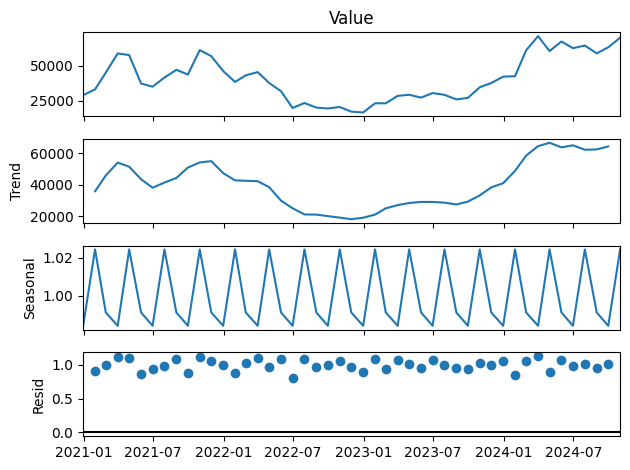

In [10]:
decomposition_mul = seasonal_decompose(df["Value"], model="multiplicative", period=3)
decomposition_mul.plot()
plt.show()

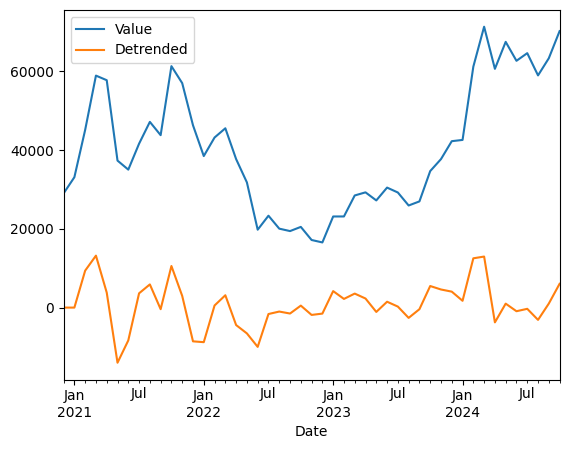

In [11]:
rolling_mean = df["Value"].rolling(3).mean()
df["Detrended"] = df["Value"] - rolling_mean
df["Detrended"] = df["Detrended"].fillna(0)
# df["Detrended"] = np.sqrt(df["Value"].values)
# df["Detrended"] = df["Value"].diff(1).diff(1).diff(1).fillna(0)
# df["Detrended"] = df["Value"] - decomposition_add.trend
# df["Detrended"] = df["Detrended"].fillna(0)
df["Value"].plot()
df["Detrended"].plot()
plt.legend(["Value","Detrended"])
plt.show()

In [12]:
check_stationarity(df["Detrended"])

ADF Statistic: -5.487616
p-value: 0.000002
Critical Values:
	1%: -3.585
	5%: -2.928
	10%: -2.602
Stationary


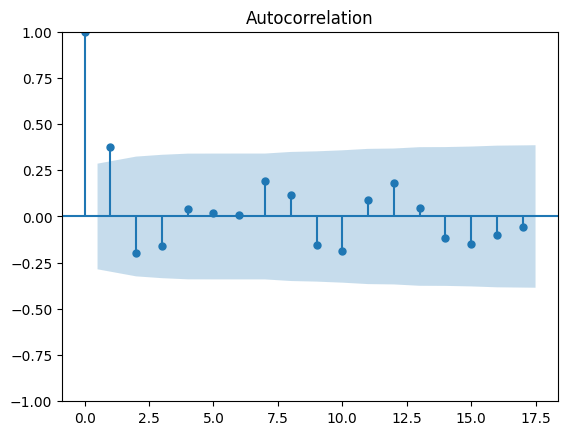

In [13]:
plot_acf(df["Detrended"])
plt.show()

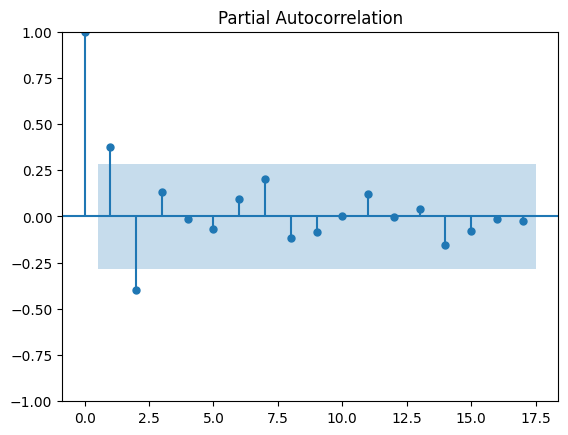

In [14]:
plot_pacf(df["Detrended"])
plt.show()

In [15]:
samples = df["Detrended"].copy()
n = len(samples)
train_size = int(n*0.9)
train_samples = samples[:train_size].copy()
test_samples = samples[train_size:].copy()

p, d, q = 1, 0, 2
model = ARIMA(train_samples, order=(p, d, q))
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Detrended   No. Observations:                   42
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -417.726
Date:                Thu, 07 Nov 2024   AIC                            845.452
Time:                        14:03:24   BIC                            854.141
Sample:                    12-31-2020   HQIC                           848.637
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        796.7404    982.559      0.811      0.417   -1129.041    2722.521
ar.L1          0.4737      1.113      0.426      0.670      -1.707       2.654
ma.L1          0.1102      1.053      0.105      0.9

/opt/conda/envs/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


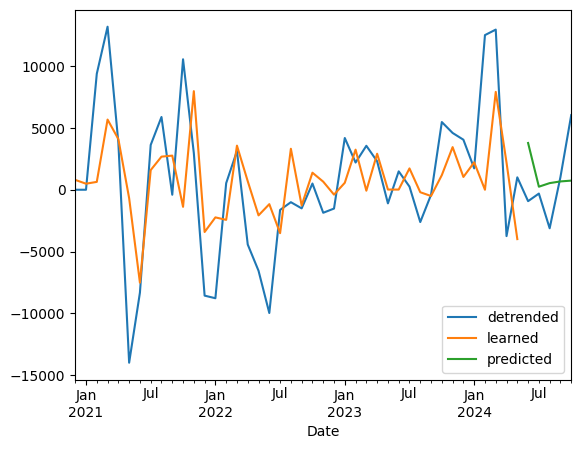

In [16]:
forecast = fitted_model.forecast(steps=len(test_samples))
forecast.index = test_samples.index

df.Detrended.plot()
learned = fitted_model.predict()
learned.plot()
forecast.plot()

plt.legend(["detrended","learned","predicted"])
plt.show()

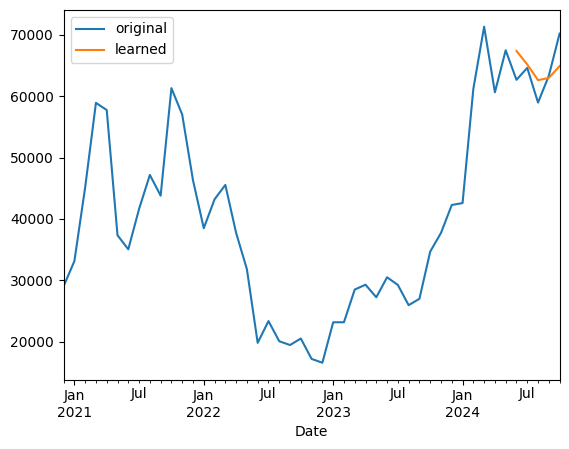

In [17]:
df.Value.plot()
learned = learned + rolling_mean
predicted = forecast + rolling_mean[-len(test_samples):]
predicted.plot()
plt.legend(["original","learned","predicted"])
plt.show()

In [18]:
mae_train = np.abs((train_samples+rolling_mean[:len(train_samples)]) - learned).mean()
mae_test = (np.abs((test_samples+rolling_mean[-len(test_samples):]) - predicted)).mean()
print(f"MAE (train): {mae_train}, MAE (test): {mae_test}")

MAE (train): 3836.78942541789, MAE (test): 2915.053433771478
